#### Imports

In [2]:
import torch
import pandas as pd
import numpy as np
import torch.utils.data as data

#### Data set loading and initial processing

In [61]:
df = pd.read_csv("./data/data.csv")
df = df.drop(["casual", "registered", "dteday", "instant"], axis=1)

df["season"] = (df["season"] - 1) / (4 - 1)
df["mnth"] = (df["mnth"] - 1) / (12 - 1)
df["hr"] = (df["hr"] - 0) / (23 - 0)
df["weekday"] = (df["weekday"] - 0) / (6 - 0)

features_cols = df.columns[:-1]

train = df.sample(frac=0.8, random_state=213)
test = df.drop(train.index)
valid = train.sample(frac=0.25, random_state=123)
train = train.drop(valid.index)

max_cnt = train["cnt"].max()
min_cnt = train["cnt"].min()
mean_cnt = train["cnt"].mean()
std_cnt = train["cnt"].std()

train["cnt"] = (train["cnt"] - min_cnt) / (max_cnt - min_cnt)
valid["cnt"] = (valid["cnt"] - min_cnt) / (max_cnt - min_cnt)
test["cnt"] = (test["cnt"] - min_cnt) / (max_cnt - min_cnt)

# train["cnt"] = (train["cnt"] - mean_cnt) / std_cnt
# valid["cnt"] = (valid["cnt"] - mean_cnt) / std_cnt
# test["cnt"] = (test["cnt"] - mean_cnt) / std_cnt


train

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
1994,0.333333,0,0.363636,0.000000,0,0.333333,1,1,0.48,0.4697,0.63,0.0000,0.017418
7239,0.333333,1,0.363636,0.000000,0,0.333333,1,2,0.50,0.4848,0.59,0.1940,0.034836
9540,1.000000,1,0.818182,0.913043,0,0.166667,1,2,0.54,0.5152,0.73,0.1343,0.222336
10690,1.000000,1,1.000000,0.869565,0,0.333333,1,1,0.32,0.3030,0.53,0.2239,0.262295
8038,0.333333,1,0.454545,0.304348,0,0.833333,1,1,0.56,0.5303,0.83,0.1642,0.439549
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,0.333333,0,0.454545,0.173913,0,0.000000,0,2,0.66,0.6212,0.74,0.1343,0.016393
2840,0.666667,0,0.545455,0.260870,0,0.666667,1,2,0.64,0.5758,0.89,0.1343,0.119877
5864,0.000000,1,0.000000,0.565217,0,0.666667,1,1,0.22,0.2121,0.47,0.2836,0.126025
7134,0.333333,1,0.272727,0.652174,0,0.000000,0,1,0.70,0.6364,0.39,0.3881,0.631148


In [62]:
train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-1]),torch.from_numpy(train.values[:,-1]))
valid_dataset = data.TensorDataset(torch.from_numpy(valid.values[:,:-1]),torch.from_numpy(valid.values[:,-1]))
test_dataset = data.TensorDataset(torch.from_numpy(test.values[:,:-1]),torch.from_numpy(test.values[:,-1]))

BATCH_SIZE = 128

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


#### Model

In [63]:
from typing import Callable
import torch.nn as nn
import torch.nn.functional as F

In [64]:
class SimpleMultiLayerNet(nn.Module):
    """
    What the name says
    """

    def __init__(
            self,
            input_size: int,
            output_size: int,
            activation: Callable | None = None,
            output_func: Callable | None = None,
            layers: list[int | float] | None = None
        ) -> None:
        super().__init__(

        )
        self.layers = nn.ModuleList([])
        self.last_layer: nn.Module
        self.activation: callable = activation
        self.output_func: callable = output_func

        in_size = input_size
        for layer_size in layers:
            if layer_size >= 1:
                self.layers.append(nn.Linear(in_features=in_size, out_features=layer_size))
                in_size = layer_size
            else:
                self.layers.append(nn.Dropout(layer_size))
        self.last_layer = nn.Linear(in_features=in_size, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x.float()
        for layer in self.layers:
            out = layer(out)
            if isinstance(layer, nn.Linear):
                out = self.activation(out)
        out = self.last_layer(out)
        return self.output_func(out) if self.output_func is not None else out
        

#### Trainer

In [65]:
class Trainer:
    """
    Class responsible for training the model
    """

    def __init__(
            self,
            model: nn.Module,
            optim: torch.optim.Optimizer,
            loss: Callable,
            train_dataloader: data.DataLoader,
            valid_dataloader: data.DataLoader,
            test_dataloader: data.DataLoader,
            verbose: bool = True
        ):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = model.to(self.device)
        self.optim = optim
        self.loss = loss
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.verbose = verbose
        self.history: list[tuple[float, float, float, float]] = []


    def evaluate(self, eval_dataloader: data.DataLoader) -> float:
        """
        Evlauates the model on given dataset
        """
        losses = []
        self.model.eval()
        with torch.no_grad():
            for features, labels in eval_dataloader:
                features = features.to(self.device)
                labels = labels.to(self.device)

                predictions = self.model(features).squeeze(dim=1)

                loss = self.loss(predictions, labels.float())
                losses.append(loss.item())
        return sum(losses) / len(losses)

    
    def train_one_epoch(self) -> None:
        """
        Trains one epoch
        """
        losses = []
        self.model.train()
        for features, labels in self.train_dataloader:
            features = features.to(self.device)
            labels = labels.to(self.device)

            predictions = self.model(features).squeeze(dim=1)

            loss = self.loss(predictions, labels.float())

            self.optim.zero_grad()

            loss.backward()

            self.optim.step()

            losses.append(loss.item())
        self.history.append(
            (sum(losses)/len(losses), self.evaluate(self.valid_dataloader))
        )
    
    def train(self, epochs: int, early_stoping: int = 0) -> None:
        """
        Trains model
        """
        min_loss = None
        without_progress = 0
        try:
            for epoch in range(epochs):
                self.train_one_epoch()
                if self.verbose is True:
                    train_loss, valid_loss = self.history[-1]
                    print(
                        f"Epoch: {epoch}\t Train loss: {train_loss:.4}\t Validation loss: {valid_loss:.4}"
                    )
                if early_stoping > 0:
                    _, valid_loss = self.history[-1]
                    if min_loss is None:
                        min_loss = valid_loss
                    elif min_loss > valid_loss:
                        min_loss = valid_loss
                        without_progress = 0
                    else:
                        without_progress += 1
                    
                    if without_progress >= early_stoping:
                        break
        except KeyboardInterrupt:
            pass

        if self.verbose is True:
            test_loss = self.evaluate(self.test_dataloader)
            print(f"Test loss: {test_loss:.4}")
            torch.save(self.model.state_dict(), "model.pth")

#### Training

In [66]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [67]:
def accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    return float(torch.sum(torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1)) / len(labels))

def mse_accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    min_val = 3
    max_val = 9
    return float(torch.sum(torch.round(predictions * (max_val - min_val)) == labels * (max_val - min_val)) / len(labels))

def rmsle(y_true,y_pred):
    n = len(y_true)
    msle = torch.mean(torch.Tensor([(torch.log(max(y_pred[i],0) + 1) - torch.log(y_true[i] + 1)) ** 2.0 for i in range(n)]))
    return torch.sqrt(msle)


In [70]:
# hyperparameters
IN_SIZE = 12
OUT_SIZE = 1
LAYERS = [1024, 512]
ACTIVATION = F.tanh
OUTPUT_FUNC = None
LR = 0.001
EPOCHS = 10000
EARLY_STOPPING = 0

model = SimpleMultiLayerNet(
    input_size=IN_SIZE,
    output_size=OUT_SIZE,
    activation=ACTIVATION,
    output_func=OUTPUT_FUNC,
    layers=LAYERS
)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

trainer = Trainer(
    model=model,
    optim=optimizer,
    loss=loss,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    test_dataloader=test_dataloader,
)

trainer.train(epochs=EPOCHS, early_stoping=EARLY_STOPPING)

/home/pawel/anaconda3/envs/ssne/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0	 Train loss: 0.6367	 Validation loss: 0.02183
Epoch: 1	 Train loss: 0.02362	 Validation loss: 0.02074
Epoch: 2	 Train loss: 0.02135	 Validation loss: 0.02126
Epoch: 3	 Train loss: 0.02123	 Validation loss: 0.02062
Epoch: 4	 Train loss: 0.02102	 Validation loss: 0.02033
Epoch: 5	 Train loss: 0.02109	 Validation loss: 0.02138
Epoch: 6	 Train loss: 0.02081	 Validation loss: 0.02026
Epoch: 7	 Train loss: 0.02073	 Validation loss: 0.01986
Epoch: 8	 Train loss: 0.02044	 Validation loss: 0.01983
Epoch: 9	 Train loss: 0.0201	 Validation loss: 0.01954
Epoch: 10	 Train loss: 0.01971	 Validation loss: 0.01876
Epoch: 11	 Train loss: 0.01869	 Validation loss: 0.01776
Epoch: 12	 Train loss: 0.01805	 Validation loss: 0.01647
Epoch: 13	 Train loss: 0.01725	 Validation loss: 0.01785
Epoch: 14	 Train loss: 0.01684	 Validation loss: 0.01564
Epoch: 15	 Train loss: 0.01557	 Validation loss: 0.01438
Epoch: 16	 Train loss: 0.01502	 Validation loss: 0.0144
Epoch: 17	 Train loss: 0.01482	 Validation l

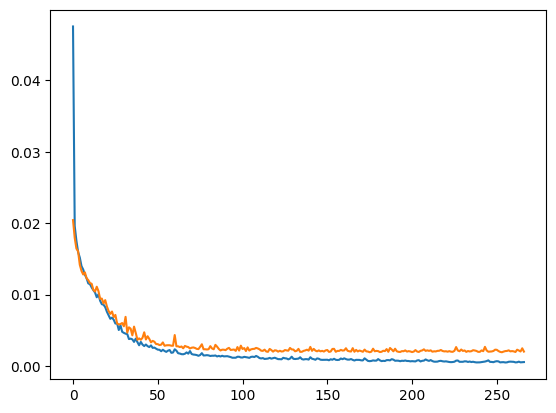

In [ ]:
import matplotlib.pyplot as plt

train_loss = [train_loss for train_loss,  valid_loss in trainer.history]
valid_loss = [valid_loss for train_loss, valid_loss in trainer.history]

plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(valid_loss)), valid_loss)


#### Make predictions

In [ ]:
df_eval = pd.read_csv("./data/evaluation_data.csv")
df_eval = df_eval.drop(["dteday"], axis=1)

df_eval["season"] = (df_eval["season"] - 1) / (4 - 1)
df_eval["mnth"] = (df_eval["mnth"] - 1) / (12 - 1)
df_eval["hr"] = (df_eval["hr"] - 0) / (23 - 0)
df_eval["weekday"] = (df_eval["weekday"] - 0) / (6 - 0)

eval = torch.tensor(df_eval.values).to(trainer.device)

preds = model(eval)
preds = (preds * (max_cnt - min_cnt)) + min_cnt
preds = F.relu(preds)
preds = torch.Tensor.cpu(preds).detach().numpy()
tmp = pd.DataFrame(preds)
tmp.to_csv("predictions.csv", index=False)

preds



array([[ 13.439115 ],
       [  7.017776 ],
       [  3.9746761],
       ...,
       [176.09593  ],
       [157.57388  ],
       [127.86947  ]], dtype=float32)